# Slice full text data based on metadata 

In this notebook I load and clean the metadata, write functions for selecting a subset of the full texts based on metadata (year written or keyword), and plot the distributions of this metadata in our corpus.

NOTE: FUNCTIONS TO GET OUR FULL TEXT CORPUS AS A DICTIONARY OR SIMPLE FILE; SELECT A SUBSET OF TEXTS BASED ON METADATA; LOAD CLEAN METADATA TABLES; AND THE LIST OF WORDS WE ARE CURRENTLY LOOKING FOR IN THE TEXT ARE IN UV.PY -- **PLEASE IMPORT AND USE FUNCTIONS/WORD LIST FROM UV.PY TO KEEP THINGS UNIFORM ACROSS ANALYSES AND NOTEBOOKS.**

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
%matplotlib inline
import uv

/Users/cdeljunco/.pyenv/versions/3.9.7/envs/nlp/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [7]:
python -m spacy download en_core_web_sm

SyntaxError: invalid syntax (581980377.py, line 1)

### Load full texts

Load full texts and put them in dictionaries where the key is the text ID and the value is the corresponding cleaned list of tokens. Since I'm assuming we didn't do OCR, I'm leaving out texts that were scanned.

In [5]:
with open('../Cleaned-Data/cleaned_texts_pdf.json') as json_file:
    cleaned_texts_pdf = json.load(json_file)
with open('../Cleaned-Data/cleaned_texts_epub_txt.json') as json_file:
    cleaned_texts_epub_txt = json.load(json_file)

cln_txts_eu_dict = {}

#the keys in our input json files are file names with extensions. 
#remove extensions so that the dictionary keys match the IDs in the metadata table.
for key, val in cleaned_texts_pdf.items():
    new_key = key.split('.')[0]
    if "scanned" not in new_key:
        cln_txts_eu_dict[new_key] = val
for key, val in cleaned_texts_epub_txt.items():
    new_key = key.split('.')[0]
    if "scanned" not in new_key:
        cln_txts_eu_dict[new_key] = val

with open('../Cleaned-Data/cleaned_texts_dystopia.json') as json_file:
    cleaned_texts_dystopia = json.load(json_file)
    
cln_txts_dys_dict = {}
    
for key, val in cleaned_texts_dystopia.items():
    new_key = key.split('.')[0]
    if "scanned" not in new_key:
        cln_txts_dys_dict[key.split('.')[0]] = val

print(len(cln_txts_dys_dict))
print(len(cln_txts_eu_dict))
    
# #uncomment if it's convenient to have a list of the texts
# cln_txts_eu_list = [text for text in cln_txts_eu_dict.values()]
# cln_txts_dys_list = [text for text in cln_txts_dys_dict.values()]

67
721


Load lemmatized full texts

In [6]:
with open('../Cleaned-Data/lemmatized_books.json') as json_file:
    cleaned_texts = json.load(json_file)
    
print(len(cleaned_texts))

cln_txts_dict = {}

#the keys in our input json files are file names with extensions. 
#remove extensions so that the dictionary keys match the IDs in the metadata table.
for key, val in cleaned_texts_pdf.items():
    new_key = key.split('.')[0]
    if "scanned" not in new_key:
        cln_txts_eu_dict[new_key] = val
for key, val in cleaned_texts_epub_txt.items():
    new_key = key.split('.')[0]
    if "scanned" not in new_key:
        cln_txts_eu_dict[new_key] = val
        
print(len(cln_txts_eu_dict))

# with open('../Cleaned-Data/cleaned_texts_dystopia.json') as json_file:
#     cleaned_texts_dystopia = json.load(json_file)
    
# cln_txts_dys_dict = {}
    
# for key, val in cleaned_texts_dystopia.items():
#     new_key = key.split('.')[0]
#     if "scanned" not in new_key:
#         cln_txts_dys_dict[key.split('.')[0]] = val

725
721


### Load metadata

In [3]:
book_info_eutopia = pd.read_csv("../Biblists/eutopia_september9.csv")
book_info_eutopia = pd.concat([book_info_eutopia, pd.read_csv("../Biblists/bib_list_cdj_july6.csv")], ignore_index=True, verify_integrity = True)

book_info_dystopia = pd.read_csv("../Biblists/dystopia_september18.csv")

del book_info_eutopia['Unnamed: 0']
del book_info_dystopia['Unnamed: 0']

### Clean metadata

Clean it up. Note that the **book ID is a string** not an int and some of them contain 'scanned' (if Jode could only find a scanned copy). Since I'm assuming that we haven't used OCR I'm removing those here.

I'm also removing duplicates based on only a subset of columns. For instance, the metadata table has several entries for ID '4505' which are the same except for the field 'Jode notes'. I'm ignoring that column when looking for duplicates, which means some of Jode's notes may be lost. (But only from the dataframe, of course they are still in the files.)

In [4]:
book_info_eutopia.columns

Index(['author', 'title', 'url', 'ID', 'added', 'jode_notes', 'keywords',
       'abstract', 'address', 'publisher', 'month', 'year', 'howpublished',
       'ENTRYTYPE', 'editor', 'pages', 'isbn', 'note', 'volume', 'issn'],
      dtype='object')

In [5]:
book_info_eutopia = book_info_eutopia[~book_info_eutopia['ID'].isna()]
book_info_eutopia['ID'] = book_info_eutopia.ID.astype('str')
book_info_eutopia.drop_duplicates(inplace = True, subset = ['ID', 'year', 'author', 'title', 'keywords', 'note'])

In [6]:
book_info_eutopia.ID.value_counts()

11187    1
12       1
8054     1
6678     1
31       1
        ..
1865     1
1862     1
1896     1
1902     1
9603     1
Name: ID, Length: 2254, dtype: int64

In [7]:
book_info_dystopia = book_info_dystopia[~book_info_dystopia['ID'].isna()]
book_info_dystopia['ID'] = book_info_dystopia.ID.astype('str')
book_info_dystopia.drop_duplicates(inplace = True, subset = ['ID', 'year', 'author', 'title', 'keywords', 'note'])

In [8]:
book_info_dystopia.ID.value_counts()

11165    1
3277     1
3284     1
3334     1
3305     1
        ..
9332     1
6073     1
6148     1
6081     1
7081     1
Name: ID, Length: 4180, dtype: int64

In [12]:
with open('dystopia_metadata_clean.txt', 'wb') as f:
    pkl.dump(book_info_dystopia, f)
with open('eutopia_metadata_clean.txt', 'wb') as f:
    pkl.dump(book_info_eutopia, f) 


### Functions to filter full texts by metadata

In [124]:
def get_texts_year_range(year_range_lo, year_range_hi, book_info = book_info_eutopia, 
                         text_dict = cln_txts_eu_dict):
    
    ids = book_info[(book_info.year > year_range_lo) & (book_info.year <= year_range_hi)].ID.values
    texts = [text_dict[key] for key in ids if key in text_dict]
    
    print('texts in date range: ' + str(len(texts)))
    return texts
    
def get_texts_w_keyword(kw, book_info = book_info_eutopia, text_dict = cln_txts_eu_dict):
    
    possible_keywords = ['Aotearoa/New Zealand author', 'Female author', 'English author', 'Irish author', 
     'Male author', 'African author', 'Transgender author', 'US author', 'UK author', 
     'Canadian author', 'Latinx author', 'African American author', 'Cuban-American author',
     'Scottish author', 'Indian author', 'French author', 'Australian author', 
     'Czech author', 'Northern Ireland author', 'Israeli author', 'Nigerian author', 
     'South African author', 'Iranian author', 'Botswanan author', 'Armenian author', 
     'Italian author', 'German author', 'Welsh author', 'Slovenian author']
        
    if kw not in possible_keywords:
        print('no texts labeled with that keyword. possible keywords are:')
        print(possible_keywords)

    bi_no_na = book_info[~book_info.keywords.isna()]
    ids = bi_no_na[bi_no_na.keywords.str.contains(kw)].ID.values
    texts = [text_dict[key] for key in ids if key in text_dict]

    print('texts with keyword ' + kw + ': ' + str(len(texts)))
    return texts

    pd.Series.dropna
    book_info.keywords.dropna()

In [125]:
f_auth_texts = get_texts_w_keyword('Female author')

texts with keyword Female author: 154


In [126]:
m_auth_texts = get_texts_w_keyword('Male author')

texts with keyword Male author: 533


In [127]:
154 + 533

687

### Descriptive statistics of Lyman Tower Sargent bibliography and our corpus

In [136]:
our_book_info_eutopia = book_info_eutopia[book_info_eutopia.ID.isin([key for key in cln_txts_eu_dict.keys()])]
our_book_info_topia = book_info_dystopia[book_info_dystopia.ID.isin([key for key in cln_txts_dys_dict.keys()])]

In [137]:
len(eu_corpus)

721

Time

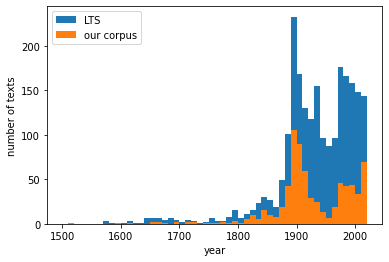

In [138]:
plt.hist(book_info_eutopia.year.values, bins = np.arange(1500, 2021, 10), label = 'LTS')
plt.hist(our_book_info_eutopia.year.values, bins = np.arange(1500, 2021, 10), label = 'our corpus')
plt.xlabel('year')
plt.ylabel('number of texts')
plt.legend()

In [164]:
#categorize keywords.
#I constructed these so that each group would only contain mutually exclusive kws.
#(not as in I believe them to be exclusive, but as in I don't expect the same work to be tagged with more than one)
#I need to double-check this is true in the data.

gender_kws = ['Female author', 'Male author']
trans_kws = ['Transgender author']
nation_kws = ['Aotearoa/New Zealand author', 'English author', 'Irish author',  
              'US author', 'UK author', 'Canadian author', 'Latinx author', 'Scottish author', 
              'Indian author', 'French author', 'Australian author', 'Czech author', 'Northern Ireland author', 
              'Israeli author', 'Nigerian author', 'South African author', 'Iranian author', 'Botswanan author', 
              'Armenian author', 'Italian author', 'German author', 'Welsh author', 'Slovenian author']

continent_kws = ['African author']

us_minority_kws = ['Cuban-American author', 'African American author']

In [170]:
def get_n_with_kw(book_info_in, kw):
    
    book_info = book_info_in[~book_info_in.keywords.isna()]

    return len(book_info[book_info.keywords.str.contains(kw)])

def get_kw_distribution(kw_list, book_info):

    kw_numbers = {}
    for kw in kw_list:
        kw_numbers[kw] = get_n_with_kw(book_info, kw)
    kw_numbers['None'] = len(book_info) - sum(val for val in kw_numbers.values())
    
    print(kw_numbers)
    return kw_numbers

def plot_pie(ax, kw_list, book_info):
    
    data = get_kw_distribution(kw_list, book_info)
    
    ax.pie([v for v in data.values()], labels = [k for k in data.keys()])
    

{'Female author': 480, 'Male author': 1574, 'None': 200}


Text(0.5, 1.0, 'LST eutopia')

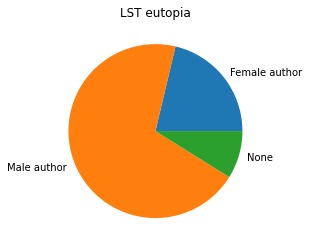

In [160]:
plot_pie(gender_kws, book_info_eutopia)
plt.title('LST eutopia')

{'Female author': 154, 'Male author': 533, 'None': 34}


Text(0.5, 1.0, 'our eutopia')

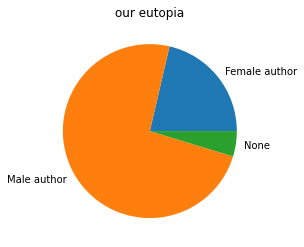

In [161]:
plot_pie(gender_kws, our_book_info_eutopia)
plt.title('our eutopia')

In [176]:
# fig, ax = plt.subplots(5, 2)

# for i, kw_list in enumerate([gender_kws, trans_kws, continent_kws, us_minority_kws]): #nation_kws, 
#     for j, bi in enumerate([book_info_eutopia, our_book_info_eutopia]):
#         plot_pie(ax[i, j], kw_list, bi)